# Does traditional features improve SotA CNNs?
- # Dataset: HIS2828
- # CNN: resnet34

In [1]:
#import numpy as np 
#import pandas as pd
import PIL
import skimage.feature
import sklearn
import torch
import fastai
import pretrainedmodels

from tqdm import tqdm_notebook
from fastai import *
from fastai.vision import *
from sklearn.model_selection import StratifiedKFold

packages = [
  ["Numpy",         np.__version__,        "Numbers"],
  ["Pandas",        pd.__version__,        "Data manipulation"],
  ["Pillow",        PIL.__version__,       "Image"],
  ["Skimage",       skimage.__version__,   "Image"],
  ["Scikit-learn",  sklearn.__version__,   "Machine learning"],
  ["Pytorch",       torch.__version__,     "Low level deep learning"],
  ["Fast.ai",       fastai.__version__,    "High level deep learning"],
  ["Cadene", pretrainedmodels.__version__, "Pretrained deep learning models"]]

new_df = pd.DataFrame(columns=["Package", "Version", "Description"], data=packages)
new_df.style.set_properties(**{'text-align': 'left'})

,Package,Version,Description
0,Numpy,1.15.4,Numbers
1,Pandas,0.24.2,Data manipulation
2,Pillow,5.4.1,Image
3,Skimage,0.14.2,Image
4,Scikit-learn,0.20.1,Machine learning
5,Pytorch,1.0.1,Low level deep learning
6,Fast.ai,1.0.51,High level deep learning
7,Cadene,0.7.4,Pretrained deep learning models


# Data

In [2]:
path     = pathlib.Path("E:/Datasets/TFM/histologyDS2828")
csv_path = path / "imageClasses.txt"
df       = pd.read_csv(csv_path, header=None, delim_whitespace=True, names=['Image', 'Label'])
df       = df.replace({'Label': {1:"Conective", 2:"Ephitelial", 3:"Muscular", 4:"Nervous"}})

###################################### Stratified 10 Fold Cross validation indexes
n_cv_folds = 10
x = df.Image.values
y = df.Label.values
train_idxs_fold = []
valid_idxs_fold = []
cross_valid = StratifiedKFold(n_splits=n_cv_folds, shuffle=True, random_state=0) # Always same random stratified CV
for i, (train_index, valid_index) in enumerate(cross_valid.split(x, y)):
    train_idxs_fold.append(train_index)
    valid_idxs_fold.append(valid_index)

##################################### Src data

src  = (ImageList.from_df(df, path, folder='imgs')
        .split_by_idxs(train_idxs_fold[0], valid_idxs_fold[0])
        .label_from_df(cols='Label'))

def get_data(bs, size):
    return (src.transform(get_transforms(flip_vert=True, max_warp=None), size=size)
            .databunch(bs=bs).normalize(imagenet_stats))

data = get_data(bs=16, size=224)

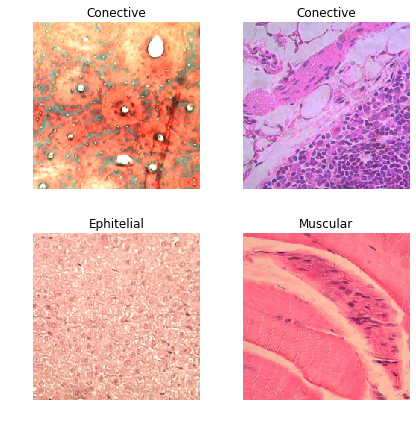

In [3]:
data.show_batch(rows=2, figsize=(6,6))

# Training

In [7]:
arch   = models.resnet34 # models.resnet50

#acc_02 = partial(accuracy_thresh, thresh=0.2)
#f_score = partial(fbeta, thresh=0.2)

learn = cnn_learner(data, arch, metrics=accuracy)

In [8]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


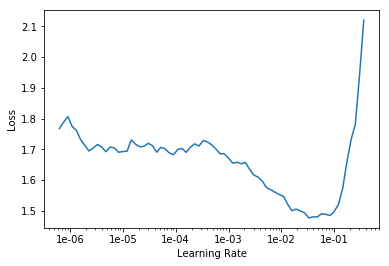

In [16]:
learn.lr_find()
learn.recorder.plot()

In [14]:
# Fastai 1.0.47 or 1.0.48, not sure
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.969502,0.880336,0.707965
2,0.760219,0.470782,0.814159
3,0.500998,0.358371,0.881416


In [20]:
# Fastai 1.0.50.post1 with databunch(num_workers=0)
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.938928,0.931984,0.670175,01:34
1,0.673785,0.451304,0.835088,01:33
2,0.507708,0.320384,0.891228,01:33


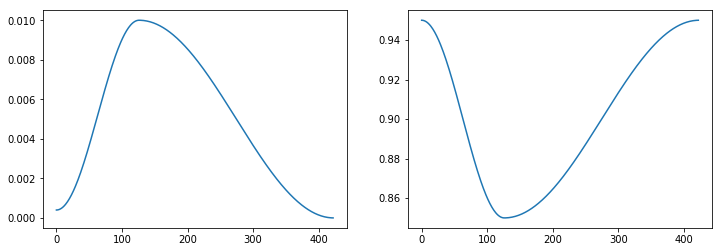

In [15]:
learn.recorder.plot_lr(show_moms=True)

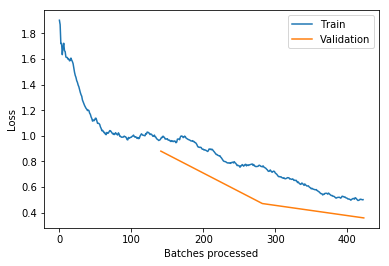

In [16]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


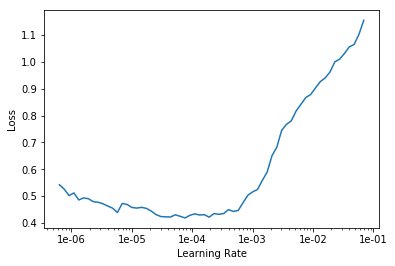

In [18]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(4, 1e-4)

epoch,train_loss,valid_loss,accuracy
1,0.423296,0.386015,0.861947
2,0.440403,0.318596,0.876106
3,0.275967,0.196806,0.936283
4,0.249080,0.178755,0.938053


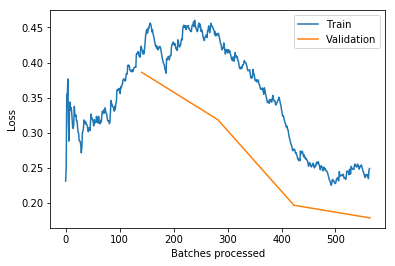

In [24]:
learn.recorder.plot_losses()

# Results

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

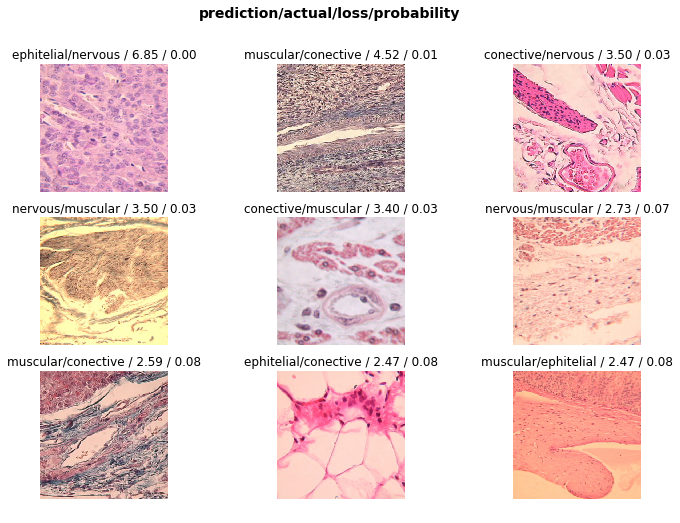

In [26]:
interp.plot_top_losses(9, figsize=(12,8))

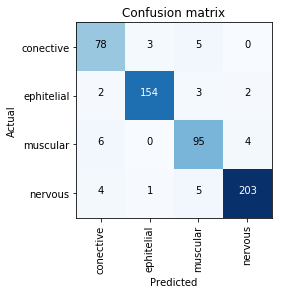

In [27]:
interp.plot_confusion_matrix()

In [28]:
interp.most_confused(min_val=2)

[('muscular', 'conective', 6),
 ('conective', 'muscular', 5),
 ('nervous', 'muscular', 5),
 ('muscular', 'nervous', 4),
 ('nervous', 'conective', 4),
 ('conective', 'ephitelial', 3),
 ('ephitelial', 'muscular', 3)]

- Other
    - Gabor filter
    - LBP:      local binary pattern
    - LTP:		local ternary pattern
    - HOG:		Histogram of Oriented Gradients
    - PHOG:		Pyramid Histogram of Oriented Gradients
    - ACC:		Auto Color Correlogram
    - BoVW:		Bag-of-Visual-Words
    - CEDD:		Color and Edge Directivity Descriptor
    - CENTRIST:	CENsus TRansform hISTogram
    - EHD:		Edge Histogram Descriptor
    - dense SIFT
    - Opponent color space

# Traditional features (70ms per image)

- **Texture features**: 4 matrices * 4 features each = 16 total features
  - First acquire the 4 gray-level co-occurrence matrices
  - Then, we employ:
    - **Angular second moment** (ASM)
    - **Entropy** (ENT)
    - **Contrast** (CON)
    - **Correlation** (COR)
- **Color moment features**: For each RGB channel compute 3 features: 3x3 = 9 features
  - First color moment (**Mean**)
  - Second color moment (**Std**)
  - Third color moment (**Skewness**)

In [31]:
def low_feats(img_name):
    img    = PIL.Image.open(img_name)
    img_bw = img.convert("L")
    img_bw = np.array(img_bw)
    img    = np.array(img)

    ######### Texture feats
    glcm = skimage.feature.texture.greycomatrix(img_bw, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], normed=True)
    props = ['ASM', 'contrast', 'correlation']
    texture_feats = [skimage.feature.texture.greycoprops(glcm, prop).ravel() for prop in props]
    texture_feats.append(np.array([skimage.measure.shannon_entropy(glcm[:,:,0,d]) for d in range(4)]))

    ######### Color feats
    mean     = np.mean(img, axis=(0,1))                           # First color moment (Mean)
    std      = np.std(img, axis=(0,1))                            # Second color moment (std)
    skewness = np.array([scipy.stats.skew(img[:, :, c].reshape(-1)) for c in range(3)]) # Third color moment (Skewness)
    color_feats = [mean, std, skewness]

    return np.hstack(texture_feats + color_feats)

def save_low_feats(imageList):
    num_samples = len(imageList)
    feats = np.empty([num_samples, 25])
    
    for i in tqdm_notebook(range(num_samples)):
        feats[i] = low_feats(imageList.items[i])

    return feats

src    = ImageList.from_df(df, path, folder='imgs')
#%time low_feats(src.items[0])
#hist_low_feats = save_low_feats(src)
#np.save('hist_low.npy', hist_low_feats)